In [1]:
# add system environment variable
import sys
sys.path.append('/workspace/ControlNet_jh/ControlNet')

import torch
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
from customs.pipes.control_inpaint_pipe import StableDiffusionControlNetInpaintPipeline
from transformers import CLIPTextModel, CLIPTokenizer
import customs.custom_api as custom_api


pretrained_model_name_or_path = "/workspace/ControlNet_jh/customs/models/diffusers/pose_razaras-superschool-1200"

# load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="text_encoder", 
    torch_dtype=torch.float16
)

# add tokens
embed_path = '/workspace/ControlNet_jh/ControlNet/embeddings'
embed_list = ['goddess','razaras-v15','superschool']
custom_api.add_token(embed_path=embed_path,tokens=embed_list,tokenizer=tokenizer,text_encoder=text_encoder)

# load model & merge
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    pretrained_model_name_or_path,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    torch_dtype=torch.float16).to('cuda')
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",torch_dtype=torch.float16).to('cuda')

pipe_control.unet = pipe_inpaint.unet
pipe_control.unet.in_channels = 4

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


goddess added to CLIP tokenizer
razaras-v15 added to CLIP tokenizer
superschool added to CLIP tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 45839.39it/s]


cuda
cuda


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


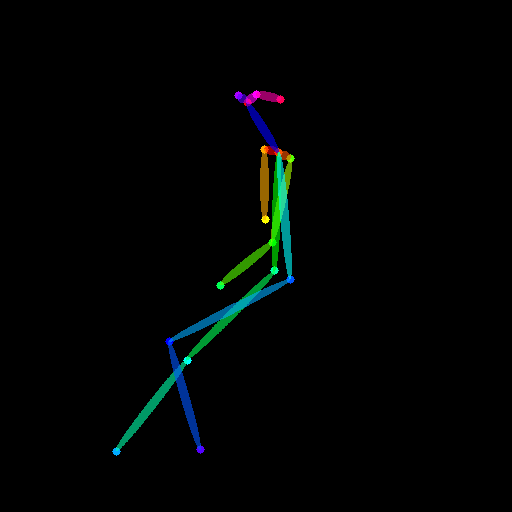

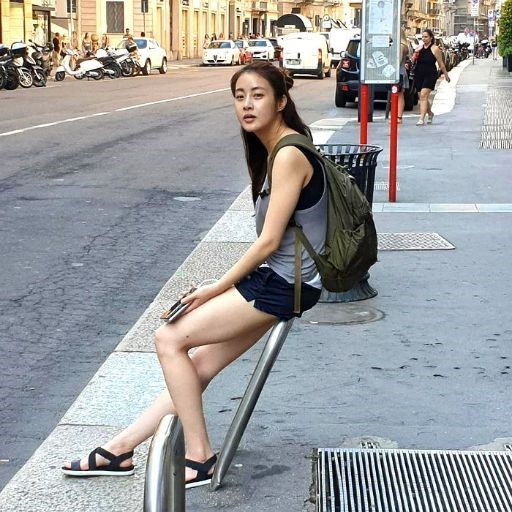

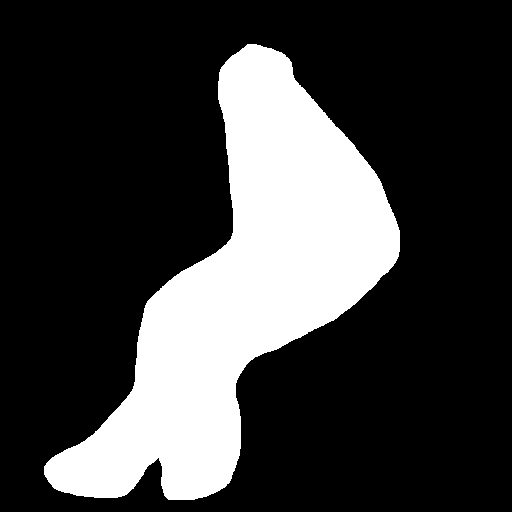

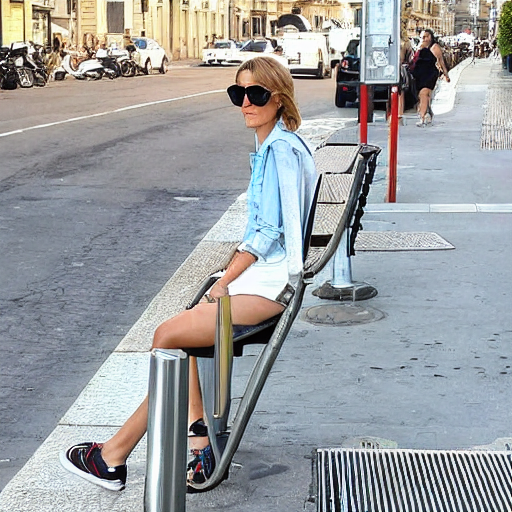

In [4]:
from ControlNet.annotator.openpose import OpenposeDetector
from ControlNet.annotator.util import HWC3
import numpy as np

# load image & mask
image = Image.open("/workspace/ControlNet_jh/customs/test_images/image1.jpg")
mask = Image.open("/workspace/ControlNet_jh/customs/test_images/image1_mask.jpg")   # 지우는 부분: [255,255,255] 아닌부분: [0,0,0]

# image preprocess
image = custom_api.resize_padding(image)
image = np.asanyarray(image)
image = HWC3(image)
mask = custom_api.resize_padding(mask)

# get condition
apply_openpose = OpenposeDetector()
detected_map, _ = apply_openpose(image)

# inputs to PIL Image
detected_map = Image.fromarray(detected_map)
image = Image.fromarray(image)

# run inference
out_image = pipe_control(
    prompt="woman leaning on bench, \
        8k, uhd, high quality, masterpiece, in superschool style and razaras style ((trending on artstation and pinterest)), detailed face, dynamic pose", 
    negative_prompt='nsfw, bad quality, letters, characters, writings, chinese chracters, watermark, username, artist name, fewer digits, \
        clevage, bad hands, chinese clothes, blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))), \
        extra limbs, (bad anatomy), gross proportions, (too many fingers), (((long neck))), Photoshop, video game, tiling, poorly drawn hands,\
        poorly drawn feet, poorly drawn face, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, \
        blurry, bad anatomy, 3d render, too many pople',
    controlnet_hint=detected_map, 
    image=image,
    mask_image=mask,
    num_inference_steps=100).images[0]


image.show()
mask.show()
detected_map.show()
out_image.show()